In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
# import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
import keyboard
import time
from IPython.display import display, clear_output
import seaborn as sns
import polars as pd

In [2]:
_parent_folder = "single_cam_dec_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\Sujith\\Documents\\Projects\\armbo\\recording_programs\\test_data\\single_cam_dec_14'

In [7]:
"""path based on text file"""
data_pth_file = open(os.path.join(os.path.dirname(os.getcwd()), "src", "data_path.txt"), "r+")
_base_pth = data_pth_file.read()
_base_pth = os.path.join(_base_pth, _parent_folder)

In [14]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files.xlsx"))
_analysis_pth = os.path.join(_base_pth, "00_analysis")
folder_df

folder_name,calibration_folder,flip
str,str,bool
"""sk18_15_forwar...","""calibration_15...",false
"""sk18_15_forwar...","""calibration_15...",false
"""sk18_15_forwar...","""calibration_15...",false
"""sk18_15_forwar...","""calibration_15...",false
"""sk18_15_forwar...","""calibration_15...",false
"""sk18_15_forwar...","""calibration_15...",false
"""sk18_15_quad_f...","""calibration_15...",false
"""sk18_15_quad_f...","""calibration_15...",false
"""sk18_15_quad_m...","""calibration_15...",false


In [35]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.clone()
    for i in range(len(df)):
        val = df[["x", "y", "z"]][i].to_numpy()[0]
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        
        df1["x"][i] = _val[0]
        df1["y"][i] = _val[1]
        df1["z"][i] = _val[2]

    return df1

In [36]:
mean_err_df = pd.DataFrame(columns=["folder_name","date_created" ,"frame_id","err_x", "err_y", "err_z",
                                     "max_err_x", "max_err_y", "max_err_z",
                                     "std_err_x", "std_err_y", "std_err_z",
                                     "offset_x", "offset_y", "offset_z"])

In [56]:
for idx, _folder_name in enumerate(tqdm(folder_df["folder_name"])):
    # print(idx)
    _phone_cam_folder = os.path.join(_analysis_pth, "coordinates_webcam_wot_4cm_corrected", _folder_name + ".csv")
    _mc_folder = os.path.join(_analysis_pth, "coordinates_mc_4cm_corrected", _folder_name + ".csv")

    _phone_cam_df = pd.read_csv(_phone_cam_folder)
    _mc_df = pd.read_csv(_mc_folder)

    #read the calibration file
    _webcam_calib_folder = folder_df["calibration_folder"][idx]
    _webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)

    with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
        webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
        _webcam_rot = next(webcam_rotmat)
        _webcam_org = next(webcam_rotmat)


    _w_df = transform_coordinates_1(_phone_cam_df, _webcam_rot, _webcam_org)

    # find the offset
    _offset_x = _w_df["x"][0] - _mc_df["x"][0]
    _offset_y = _w_df["y"][0] - _mc_df["y"][0]
    _offset_z = _w_df["z"][0] - _mc_df["z"][0]
        
    _mc_df.with_columns([
        (pd.col("x") + _offset_x).alias("x"),
        (pd.col("y") + _offset_y).alias("y"),
        (pd.col("z") + _offset_z).alias("z"),
        
    ])
    
    # filter the data
    _w_df.with_columns([
        pd.col("x").map(lambda s: savgol_filter(s, 51, 1)).alias("x"),
        pd.col("y").map(lambda s: savgol_filter(s, 51, 1)).alias("y"),
        pd.col("z").map(lambda s: savgol_filter(s, 51, 1)).alias("z"),
    ])

    
    error_df = pd.DataFrame()

    error_df.with_columns([
        (_mc_df["time"]).alias("time"),
        (_mc_df["x"] - _w_df["x"]).alias("x"),
        (_mc_df["y"] - _w_df["y"]).alias("y"),
        (_mc_df["z"] - _w_df["z"]).alias("z"),
        (_w_df["frame_id"]).alias("frame_id")
        
    ])
    # error_df["time"] = _mc_df["time"]
    # error_df["x"] = _mc_df["x"] - _w_df["x"]
    # error_df["y"] = _mc_df["y"] - _w_df["y"]
    # error_df["z"] = _mc_df["z"] - _w_df["z"]
    # error_df["frame_id"] = _w_df["frame_id"]

    # mean_err_df = mean_err_df.append({"folder_name": folder_df.folder_name[idx],"date_created": None, "frame_id":  error_df["frame_id"][0],
    #                                 "err_x": error_df["x"].mean(), "err_y": error_df["y"].mean(), "err_z": error_df["z"].mean(), 
    #                                 "max_err_x": error_df["x"].max(), "max_err_y": error_df["y"].max(), "max_err_z": error_df["z"].max(), 
    #                                 "std_err_x": error_df["x"].std(), "std_err_y": error_df["y"].std(), "std_err_z": error_df["z"].std(),
    #                                 "offset_x": _offset_x, "offset_y": _offset_y, "offset_z": _offset_z}, ignore_index=True)


    

 32%|███▏      | 32/99 [00:55<01:55,  1.72s/it]


FileNotFoundError: No such file or directory: D:\ArUco recordings\single_cam_dec_14\00_analysis\coordinates_webcam_wot_4cm_corrected\sk18_30_forward_fast.csv

In [ ]:
# save the mean error
_mean_df_pth = os.path.join(_analysis_pth, "mean_error_df_filter.csv")
mean_err_df.to_csv(_mean_df_pth, index=False)

# read the mean error df
mean_err_df = pd.read_csv(os.path.join(_analysis_pth, "mean_error_df_filter.csv"))
mean_err_df

,folder_name,date_created,frame_id,err_x,err_y,err_z,max_err_x,max_err_y,max_err_z,std_err_x,std_err_y,std_err_z,offset_x,offset_y,offset_z
0,sk20_15_forward_fast,NaN,18.0,0.004689,-0.000476,-0.005877,0.016604,0.001778,0.038128,0.005293,0.001267,0.023437,-0.006861,0.003499,-0.057249
1,sk20_15_forward_fast_2,NaN,18.0,0.004881,-0.001477,-0.013063,0.015592,0.002015,0.021826,0.005154,0.001635,0.020749,-0.007930,0.002029,-0.066881
2,sk20_15_forward_medium,NaN,18.0,0.004563,-0.000727,-0.008103,0.014164,0.003056,0.032947,0.004489,0.002031,0.020396,-0.009065,0.005028,-0.049584
3,sk20_15_forward_medium_2,NaN,18.0,0.001257,0.003356,0.017930,0.010233,0.009265,0.052813,0.004315,0.002884,0.020363,-0.013561,0.009253,-0.023167
4,sk20_15_forward_slow,NaN,18.0,-0.004162,-0.000380,-0.000400,0.002649,0.006274,0.030266,0.005189,0.002604,0.019469,-0.020875,0.003150,-0.047615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,sk20_60_sideways_fast_2,NaN,18.0,-0.000085,-0.000456,-0.001955,0.000893,0.007918,0.039428,0.001048,0.003142,0.015099,-0.004704,0.006825,-0.041001
92,sk20_60_sideways_medium,NaN,18.0,0.001384,-0.001161,-0.003046,0.006003,0.006261,0.026690,0.001294,0.002771,0.011174,-0.004278,0.009230,-0.027436
93,sk20_60_sideways_medium_2,NaN,18.0,-0.000060,0.001116,0.006864,0.012736,0.011366,0.048358,0.002972,0.003413,0.013909,-0.006346,0.012289,-0.016236
94,sk20_60_sideways_slow,NaN,18.0,0.000793,0.001343,0.009081,0.015467,0.013481,0.058640,0.004193,0.003028,0.011968,-0.005620,0.011755,-0.013828


In [9]:
# find fps using filename
fps_values = []
for i in mean_err_df.folder_name:
    _fps = i.split("_")[1]
    _fps = int(_fps)
    fps_values.append(_fps)
mean_err_df["fps"] = fps_values

# find speed of movement
speed_values = []
for i in mean_err_df.folder_name:
    _speed = i.split("_")[3]
    speed_values.append(_speed)
mean_err_df["speed"] = speed_values

#object of movement
object_values = []
for i in mean_err_df.folder_name:
    _object = i.split("_")[2]
    
    if _object == "quad":
        object_values.append("quad")
    else:
        object_values.append("skateboard")
mean_err_df["object"] = object_values

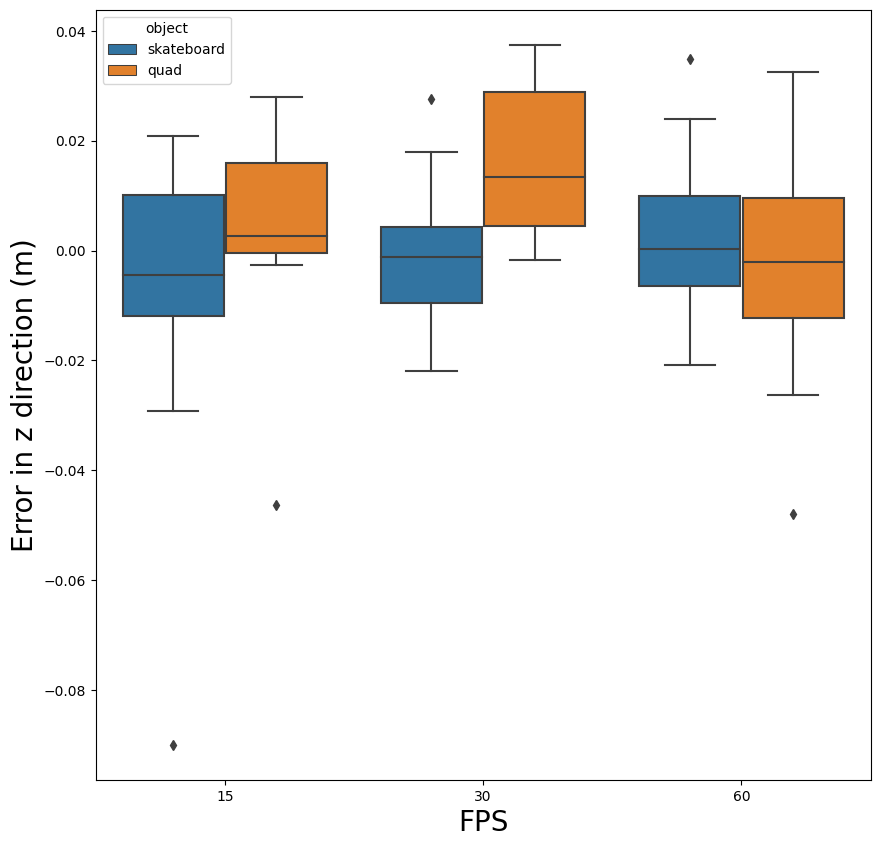

In [18]:
# box plot based on speed
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="fps", y="err_z", hue="object", data=mean_err_df, ax=ax)

# label
ax.set_xlabel("FPS", fontsize=20)
ax.set_ylabel("Error in z direction (m)", fontsize=20)
plt.show()

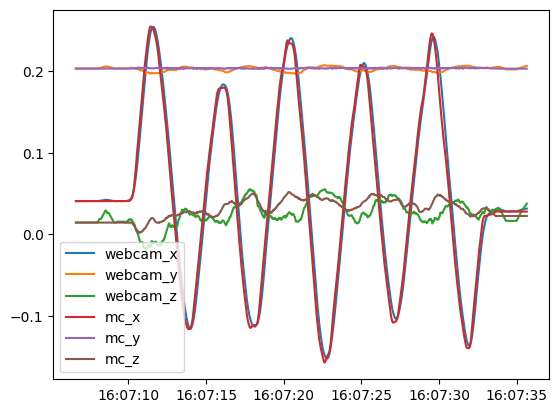

In [ ]:
# plot _w_df and _mc_df
w_df = _w_df.copy(deep=True)

w_df.x = savgol_filter(_w_df.x, 51, 1)
w_df.y = savgol_filter(_w_df.y, 51, 1)
w_df.z = savgol_filter(_w_df.z, 51, 1)
plt.plot(_w_df.time, w_df.x, label="webcam_x")
plt.plot(_w_df.time, w_df.y, label="webcam_y")
plt.plot(_w_df.time, w_df.z, label="webcam_z")
plt.plot(_mc_df.time, _mc_df.x, label="mc_x")
plt.plot(_mc_df.time, _mc_df.y, label="mc_y")
plt.plot(_mc_df.time, _mc_df.z, label="mc_z")


plt.legend()

In [24]:
grades = pd.DataFrame(
    {
        "student": ["bas", "laura", "tim", "jenny"],
        "arithmetic": [10, 5, 6, 8],
        "biology": [4, 6, 2, 7],
        "geography": [8, 4, 9, 7],
    }
)
print(grades)

shape: (4, 4)
┌─────────┬────────────┬─────────┬───────────┐
│ student ┆ arithmetic ┆ biology ┆ geography │
│ ---     ┆ ---        ┆ ---     ┆ ---       │
│ str     ┆ i64        ┆ i64     ┆ i64       │
╞═════════╪════════════╪═════════╪═══════════╡
│ bas     ┆ 10         ┆ 4       ┆ 8         │
│ laura   ┆ 5          ┆ 6       ┆ 4         │
│ tim     ┆ 6          ┆ 2       ┆ 9         │
│ jenny   ┆ 8          ┆ 7       ┆ 7         │
└─────────┴────────────┴─────────┴───────────┘


In [31]:
grades[["student", "arithmetic"]][1].to_numpy()[0]

array(['laura', 5], dtype=object)